In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gearbox-fault-diagnosis/BrokenTooth/b30hz10.csv
/kaggle/input/gearbox-fault-diagnosis/BrokenTooth/b30hz60.csv
/kaggle/input/gearbox-fault-diagnosis/BrokenTooth/b30hz70.csv
/kaggle/input/gearbox-fault-diagnosis/BrokenTooth/b30hz0.csv
/kaggle/input/gearbox-fault-diagnosis/BrokenTooth/b30hz20.csv
/kaggle/input/gearbox-fault-diagnosis/BrokenTooth/b30hz80.csv
/kaggle/input/gearbox-fault-diagnosis/BrokenTooth/b30hz40.csv
/kaggle/input/gearbox-fault-diagnosis/BrokenTooth/b30hz30.csv
/kaggle/input/gearbox-fault-diagnosis/BrokenTooth/b30hz90.csv
/kaggle/input/gearbox-fault-diagnosis/BrokenTooth/b30hz50.csv
/kaggle/input/gearbox-fault-diagnosis/Healthy/h30hz20.csv
/kaggle/input/gearbox-fault-diagnosis/Healthy/h30hz70.csv
/kaggle/input/gearbox-fault-diagnosis/Healthy/h30hz50.csv
/kaggle/input/gearbox-fault-diagnosis/Healthy/h30hz60.csv
/kaggle/input/gearbox-fault-diagnosis/Healthy/h30hz90.csv
/kaggle/input/gearbox-fault-diagnosis/Healthy/h30hz10.csv
/kaggle/input/gearbox-fault-diagn

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import fft, signal, stats
from tqdm.notebook import tqdm

# About the data
The [dataset description](https://www.kaggle.com/datasets/brjapon/gearbox-fault-diagnosis) includes the following details:
```
Gearbox Fault Diagnosis Data set include the vibration dataset recorded by using SpectraQuest’s Gearbox Fault Diagnostics Simulator.
Dataset has been recorded using 4 vibration sensors placed in four different direction, and under variation of load from '0' to '90' percent. Two different scenario are included:
1) Healthy condition and
2) Broken Tooth Condition
There are 20 files in total, 10 for healthy gearbox and 10 from broken one. Each file corresponds to a given load from 0% to 90% in steps of 10%.
```

The filename structure is indicative of the contents of the file:
* First character being "h" for the healthy gearbox, "b" for the gearbox with the broken tooth
* Last 1-2 characters being the gearbox load (0-90) during the measurement

Between those pieces of information, each filename has the characters "30hz".

We can interpret this to mean that the vibration data was collected at a data rate of 30Hz. This gives us information on the duration of the data collection in each file (i.e. number of samples / 30 = time in seconds), and also allows us to interpret the data as a continuous signal and analyze the data in the frequency domain as well as the time domain.

In [4]:
dfs = []
for dirname, _, filenames in tqdm(os.walk('/kaggle/input')):
    for filename in tqdm(filenames, leave=False):
        
        # the gearbox state is in the filename prefix (h = healthy, b = broken tooth)
        state = filename[0]
        
        # the load is in the filename suffix
        load = int(filename.split('.')[0][5:])
        
        # read in the file
        df = pd.read_csv(os.path.join(dirname, filename))
        
        # include the healthy/broken state
        df['state'] = state
        
        # include the load
        df['load'] = load
        
        # append to a list
        dfs.append(df)

# concatenate all the datasets and reset the index
df = pd.concat(dfs).reset_index().rename(columns={'index':'sample_index'})

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
df.head()

,sample_index,a1,a2,a3,a4,state,load
0,0,1.260410,-1.35726,-1.916330,1.84570,b,10
1,1,-0.126204,-2.27283,0.536155,1.53092,b,10
2,2,-0.903164,-1.04204,-0.741337,1.65011,b,10
3,3,-1.693560,2.79295,-0.066998,2.01735,b,10
4,4,-3.556980,2.11411,0.225473,2.32982,b,10


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2021119 entries, 0 to 2021118
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   sample_index  int64  
 1   a1            float64
 2   a2            float64
 3   a3            float64
 4   a4            float64
 5   state         object 
 6   load          int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 107.9+ MB


In [7]:
df.shape

(2021119, 7)

In [8]:
df.sample(3, random_state=42)

,sample_index,a1,a2,a3,a4,state,load
1583597,50926,-2.07267,-3.895440,-0.040142,-5.86337,h,10
1197075,83220,15.33900,-0.266811,-2.544860,6.91818,h,70
17675,17675,4.01382,1.450290,1.473320,-1.63767,b,10


To work with this dataset we can `melt` the readings into a "tall-form" dataset, where the reading is in a single column, tagged with the `sensor`, `load` and `state` of the gearbox.

In [11]:
sensor_readings = df.melt(
    id_vars=['sample_index','state','load'],
    value_vars=['a1','a2','a3','a4'],
    var_name='sensor',
    value_name='reading'
)
sensor_readings.head()

,sample_index,state,load,sensor,reading
0,0,b,10,a1,1.260410
1,1,b,10,a1,-0.126204
2,2,b,10,a1,-0.903164
3,3,b,10,a1,-1.693560
4,4,b,10,a1,-3.556980


# Basic EDA
We'll start with some standard analysis of the dataset.

How many samples are there in each file?

<AxesSubplot:xlabel='count', ylabel='load'>

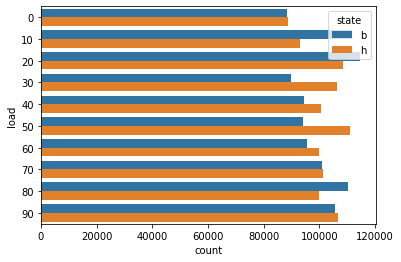

In [12]:
sns.countplot(
    data=sensor_readings[sensor_readings.sensor=='a1'],
    y='load',
    hue='state',
)

All the files have roughly the same number of samples (~85k-120k samples per file). What's the lowest number and what does this mean in terms of time?

In [13]:
#lowest number of samples
lowest_samples = df.groupby(['state','load']).sample_index.count().min()
print(f'Lowest number of samples = {lowest_samples}')
print(f'Translates to {lowest_samples/30:0.2f} seconds or {lowest_samples/30/60:0.2f} minutes')

Lowest number of samples = 88320
Translates to 2944.00 seconds or 49.07 minutes


Each file has at least 49 minutes of vibration activity.

In [15]:
# helper function to filter the dataset
def rdg(df, state=None, load=None, sensor=None):
    df_st = df[df.state==state] if state is not None else df
    df_lo = df_st[df_st.load==load] if load is not None else df_st
    df_se = df_lo[df_lo.sensor==sensor] if sensor is not None else df_lo
    return df_se
df.shape

(2021119, 7)

# Time domain analysis
What does the data from one sensor look like?

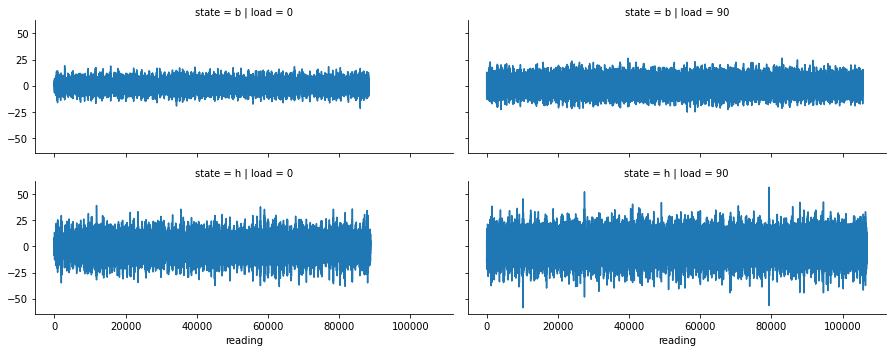

In [16]:
g = sns.FacetGrid(
    data=pd.concat([
        rdg(sensor_readings, load=0, sensor='a1'),
        rdg(sensor_readings, load=90, sensor='a1')
    ]),
    col='load',
    row='state',
    height=2.5,
    aspect=2.5
)
g.map(plt.plot, 'reading')
plt.show()

It looks like there's a difference in amplitude between the sensor readings between the healthy gearbox and the one with the broken tooth.

Is that the case across all readings?

We can use a boxenplot to show the distribution of the `reading`s and compare like for like between the healthy and broken gearboxes for the same `load` and `sensor`.

We can now use the seaborn [`catplot` function](https://seaborn.pydata.org/generated/seaborn.catplot.html) to break down the data by `load`, `sensor` and `state`, and plot the distribution of `reading` within each group.

Each row is a different sensor, each column is increasing load
Each plot shows the distribution of reading values between the healthy and broken gearbox


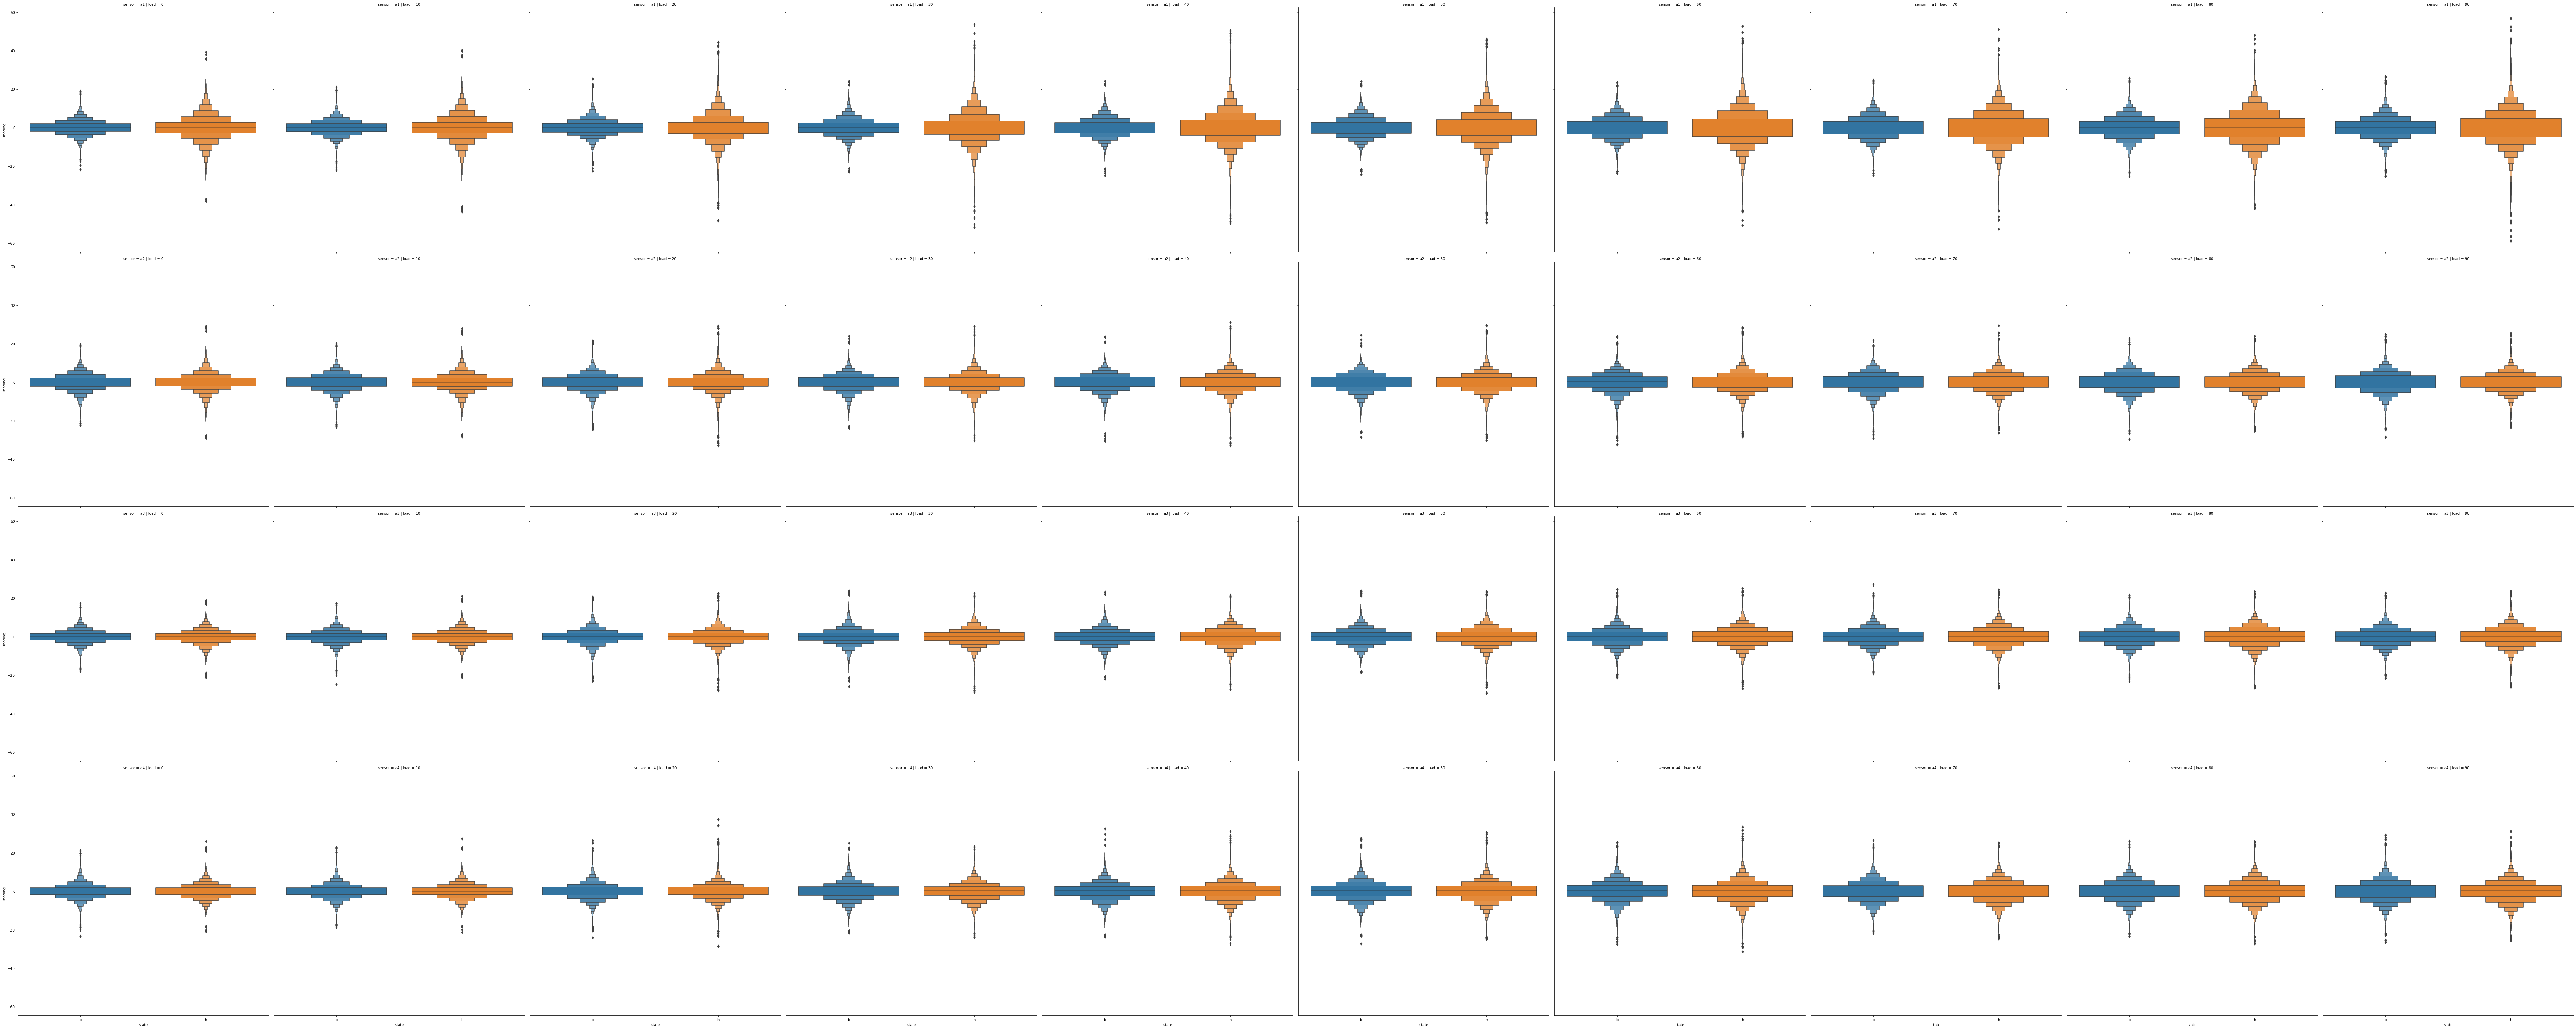

In [17]:
print('Each row is a different sensor, each column is increasing load')
print('Each plot shows the distribution of reading values between the healthy and broken gearbox')
sns.catplot(
    data=sensor_readings,
    col='load', row='sensor',
    x='state', y='reading',
    kind='boxen',
    height=10
)

Looks like there is a much bigger amplitude difference on sensor `a1`, which increases as the load increases. There's a bit of a visible difference in sensor `a2` also but not as much. The differences between sensors `a3` and `a4` don't appear to be significant.

Perhaps the "healthy" gearbox had some other issue that was causing the increased reading amplitude.

Let's look at the overall amplitude distribution for all sensors.

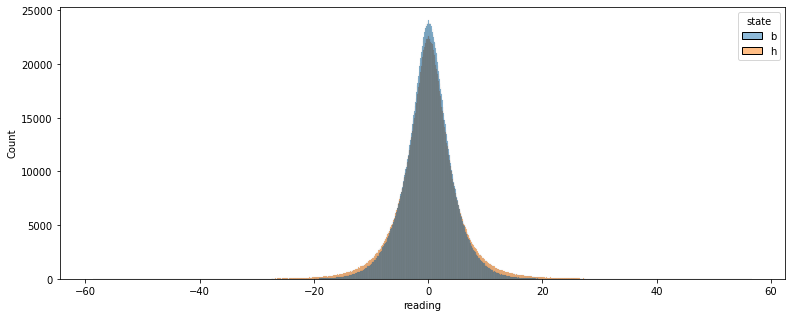

In [18]:
plt.figure(figsize=(13,5))
sns.histplot(
    data=sensor_readings,
    hue='state',
    x='reading',
)
plt.show()

Let's see what happens to the distribution if we only consider sensors a2, a3 and a4.

In [19]:
display(sensor_readings.groupby(['sensor','state']).reading.std().unstack())
print(f"Standard deviation including sensor a1: {sensor_readings.reading.std()}")
print(f"Standard deviation excluding sensor a1: {sensor_readings[sensor_readings.sensor!='a1'].reading.std()}")

state,b,h
sensor,,
a1,4.602696,7.381206
a2,4.389516,4.427153
a3,3.808909,4.110277
a4,4.408367,4.523553


Standard deviation including sensor a1: 4.822152445519267
Standard deviation excluding sensor a1: 4.285349925978809


Excluding sensor `a1` definitely brings the variation of the dataset in line with the variation within the other sensors.

In [20]:
# drop readings from sensor a1
readings = sensor_readings[sensor_readings.sensor!='a1']

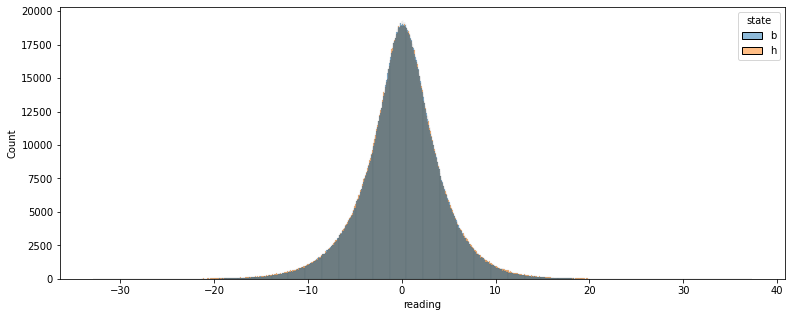

In [21]:
plt.figure(figsize=(13,5))
sns.histplot(
    data=readings,
    hue='state',
    x='reading',
)
plt.show()

There's an almost perfect overlap between the two distributions.

Now that we have a clean dataset, we can start looking at a machine learning approach that may be able to distinguish between the healthy gearbox vibrations and those from the gearbox with a broken tooth.

We have a few steps to complete:

1. Identify and create features for each sample
1. Split the dataset into a training dataset and a test dataset
1. 

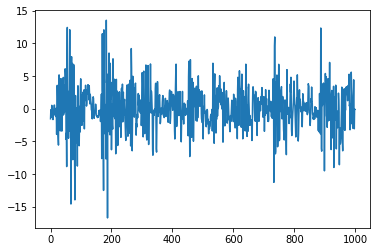

In [22]:
x = rdg(sensor_readings, 'h', 10, 'a4').reading.values[:1000]
plt.plot(x)
plt.show()

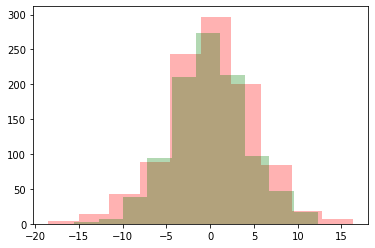

In [23]:
plt.hist(rdg(sensor_readings, 'b', 90, 'a2').reading.values[:1000], color='r', alpha=0.3) # broken tooth
plt.hist(rdg(sensor_readings, 'h', 90, 'a2').reading.values[:1000], color='g', alpha=0.3) # healthy
plt.show()

In [24]:
data = []
labels = []
for (state,load,sensor),g in sensor_readings.groupby(['state','load','sensor']):
    vals = g.reading.values
    splits = np.split(vals, range(1000,vals.shape[0],1000))
    for s in splits[:-1]:  # except the last one
        data.append({
            'sensor_a1': int(sensor=='a1'),
            'sensor_a2': int(sensor=='a2'),
            'sensor_a3': int(sensor=='a3'),
            # no need to put a4: if a1-3 are 0, then it's sensor a4
            'load': load,
            'mean': np.mean(s),
            'std': np.std(s),
            'kurt': stats.kurtosis(s),
            'skew': stats.skew(s),
            'moment': stats.moment(s),
        })
        labels.append(int(state=='b'))  # positive label indicates fault

df_data = pd.DataFrame(data)
data = df_data.values
labels = np.array(labels)
(data.shape, labels.shape)

((8036, 9), (8036,))

In [25]:
print(f'Total samples: {len(labels)}')
print(f'Fault class: {np.sum(labels)} ({np.sum(labels)/len(labels):0.1%})')

Total samples: 8036
Fault class: 4000 (49.8%)


In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data, labels,
    train_size=0.8,
    random_state=42,
    stratify=labels
)
print(f'Training data: {X_train.shape}')
print(f'Test data: {X_test.shape}')

Training data: (6428, 9)
Test data: (1608, 9)


In [27]:
from tpot import TPOTClassifier

In [30]:
%%time
tpot_td = TPOTClassifier(generations=5, random_state=42, max_time_mins=2)
tpot_td.fit(X_train, y_train)
print(f'Best accuracy score: {tpot_td.score(X_test, y_test):0.3%}')

Best accuracy score: 85.572%
CPU times: user 14.5 s, sys: 408 ms, total: 14.9 s
Wall time: 14.5 s


In [31]:
pd.Series([
    model.split('(')[0]
    for model
    in tpot_td.evaluated_individuals_.keys()
]).value_counts()

GaussianNB                1
RandomForestClassifier    1
dtype: int64

# Frequency domain analysis
Looking at the vibration data across time is useful, but vibrations are occurring at different frequencies - this is very difficult to identify from the time-based analysis. A frequency analysis of the data may yield some more tangible features.

A frequency analysis uses Fourier transforms to convert signal data (e.g. vibration readings) into its component frequencies. Let's start with a single sensor reading.

In [32]:
sensor_data = rdg(sensor_readings, 'h', 10, 'a4').reading.values

46465 total number of frequency points


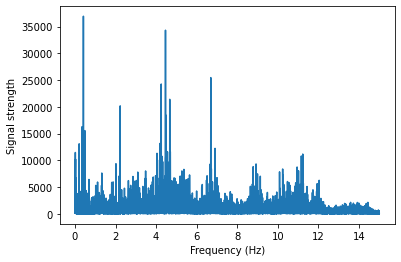

In [33]:
y = np.abs(fft.rfft(sensor_data))
x = fft.rfftfreq(sensor_data.shape[0], 1/30)  # 30Hz data rate
print(f"{y.shape[0]} total number of frequency points")

plt.plot(x, y)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Signal strength')
plt.show()

We see some peaks - let's see if we can identify those peaks:

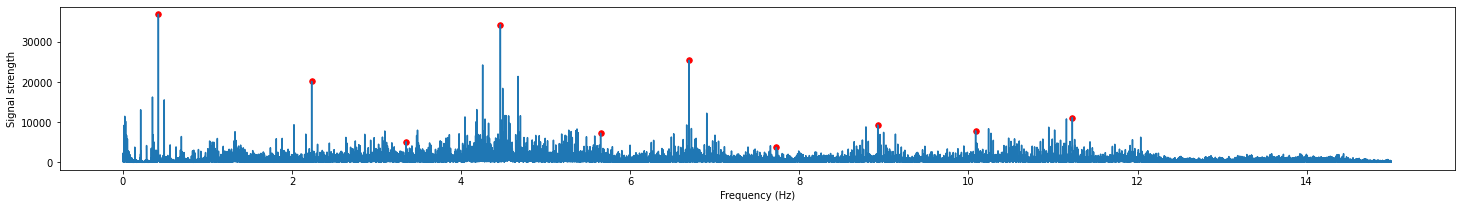

In [34]:
y = np.abs(fft.rfft(sensor_data))
x = fft.rfftfreq(sensor_data.shape[0], 1/30)  # 30Hz data rate

fig, ax = plt.subplots(figsize=(25,3))
ax.plot(x, y)

# find peaks that are
#   at least 1Hz apart (number of frequency points / max frequency)
x_peak_spacing = y.shape[0] / x.max()
#   rising above surrounding values by the 99th percentile of the values
x_peak_prominence = np.quantile(y,0.99)

peaks, _ = signal.find_peaks(y, distance=x_peak_spacing, prominence=x_peak_prominence)

for peak in peaks:
    ax.scatter(x=x[peak], y=y[peak], c='r', marker='o', s=30)

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Signal strength')
plt.show()

In [35]:
[x[peak] for peak in peaks]

[0.41838842975206614,
 2.2317277892561984,
 3.347753099173554,
 4.463455578512397,
 5.64921229338843,
 6.695506198347108,
 7.72759555785124,
 8.927233987603307,
 10.08490444214876,
 11.228693181818182]

We see primary harmonics at 2.23Hz intervals (2.23, 4.46, 6.70, etc.) and minor peaks at intervals between those (3.35, 5.65, 7.73, etc).

Another view is the Power Spectral Density:

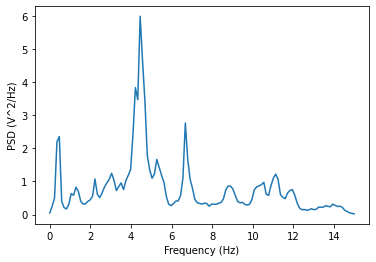

In [36]:
x, y = signal.welch(sensor_data, fs=30) # 30Hz data rate
plt.plot(x, y)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.show()

This is easier to see.

Let's plot the PSD for each sensor, at each load and compare the healthy and broken gearbox signals. We can also correlate the power values for each frequency between the healthy and broken gearboxes to see how well they line up.

The correlation between the two spetra is shown in the title of each plot

  0%|          | 0/40 [00:00<?, ?it/s]

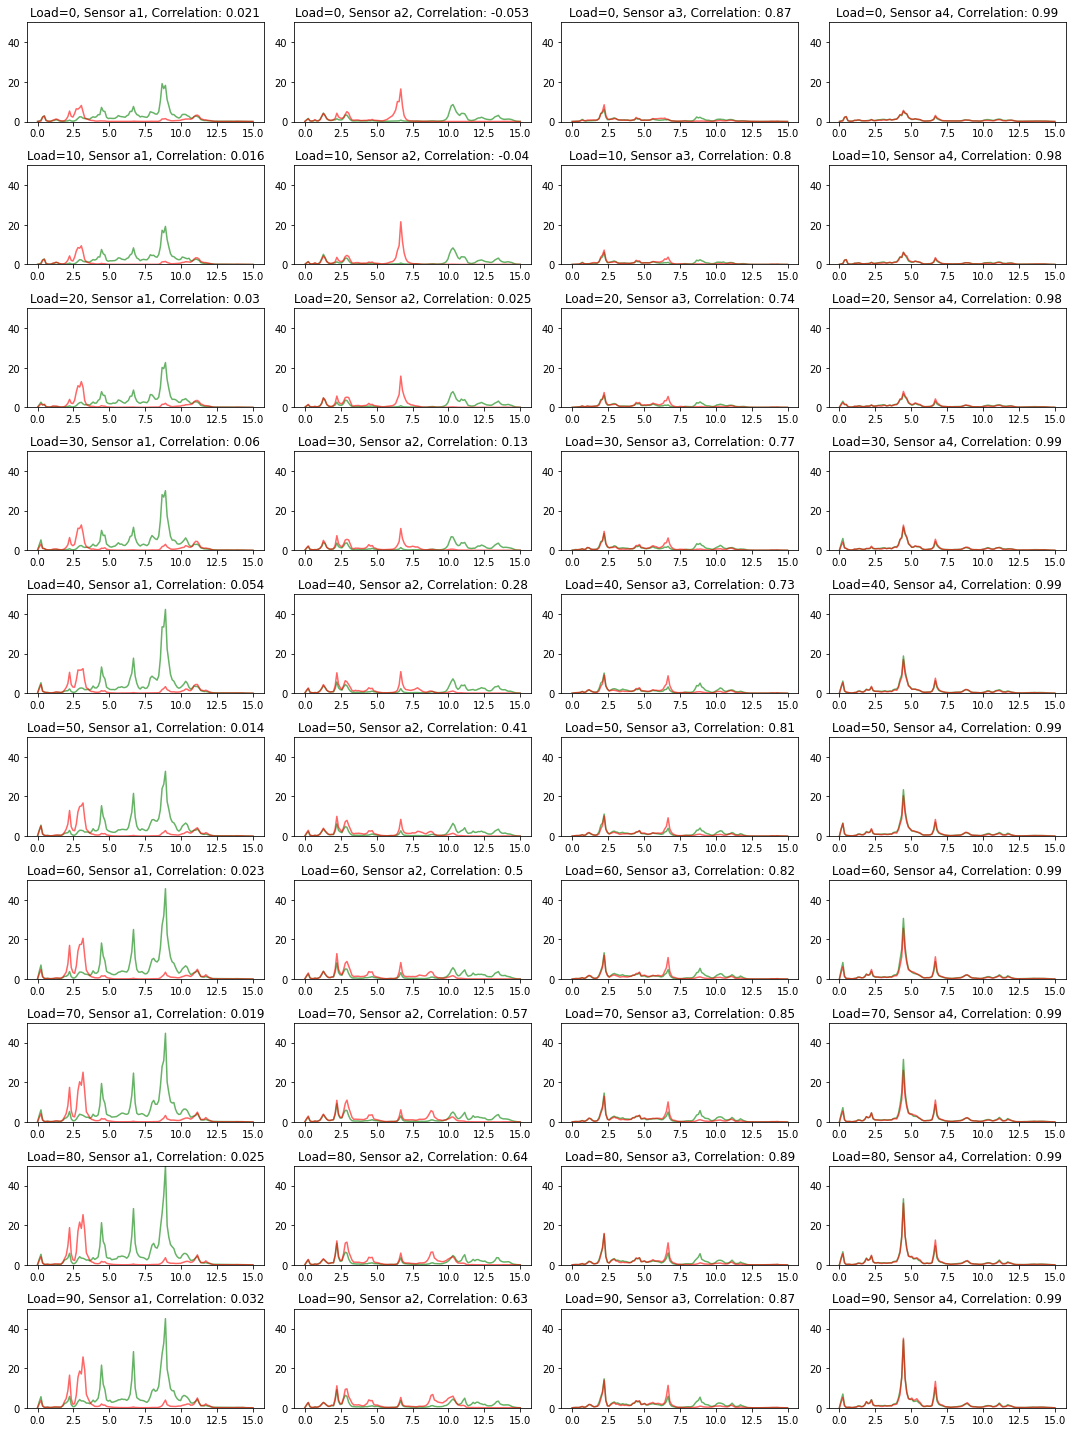

In [37]:
fig, ax = plt.subplots(ncols=4, nrows=10, figsize=(15,20))
for ((load,sensor), dfg), axi in tqdm(zip(sensor_readings.groupby(['load','sensor']), ax.ravel()), total=40):
    healthy_raw = dfg[dfg.state=='h'].reading.values
    broken_raw = dfg[dfg.state=='b'].reading.values
    
    fh, Ph = signal.welch(healthy_raw, fs=30)
    fb, Pb = signal.welch(broken_raw, fs=30)

    axi.plot(fh, Ph, c='g', alpha=0.6)
    axi.plot(fb, Pb, c='r', alpha=0.6)
    axi.set_ylim(0,50)
    axi.set_title(f'Load={load}, Sensor {sensor}, Correlation: {np.corrcoef(Ph, Pb)[0,1]:0.2}')
plt.tight_layout()
plt.show()

Here it's clear that while there's hardly any difference in the PSD on sensor `a4`, the PSD for the other sensors show marked differences. For sensors `a1`, `a2` and `a3` the signal power at the higher frequencies is much lower in the readings from the gearbox with the broken tooth. This pattern is visible across all loads.

There is also a marked peak on sensor `a2` readings at the 6.7Hz harmonic, which is more prominent at lower loads.

Let's see if the pattern changes over time. We can do this with a spectrograph view.

  0%|          | 0/80 [00:00<?, ?it/s]

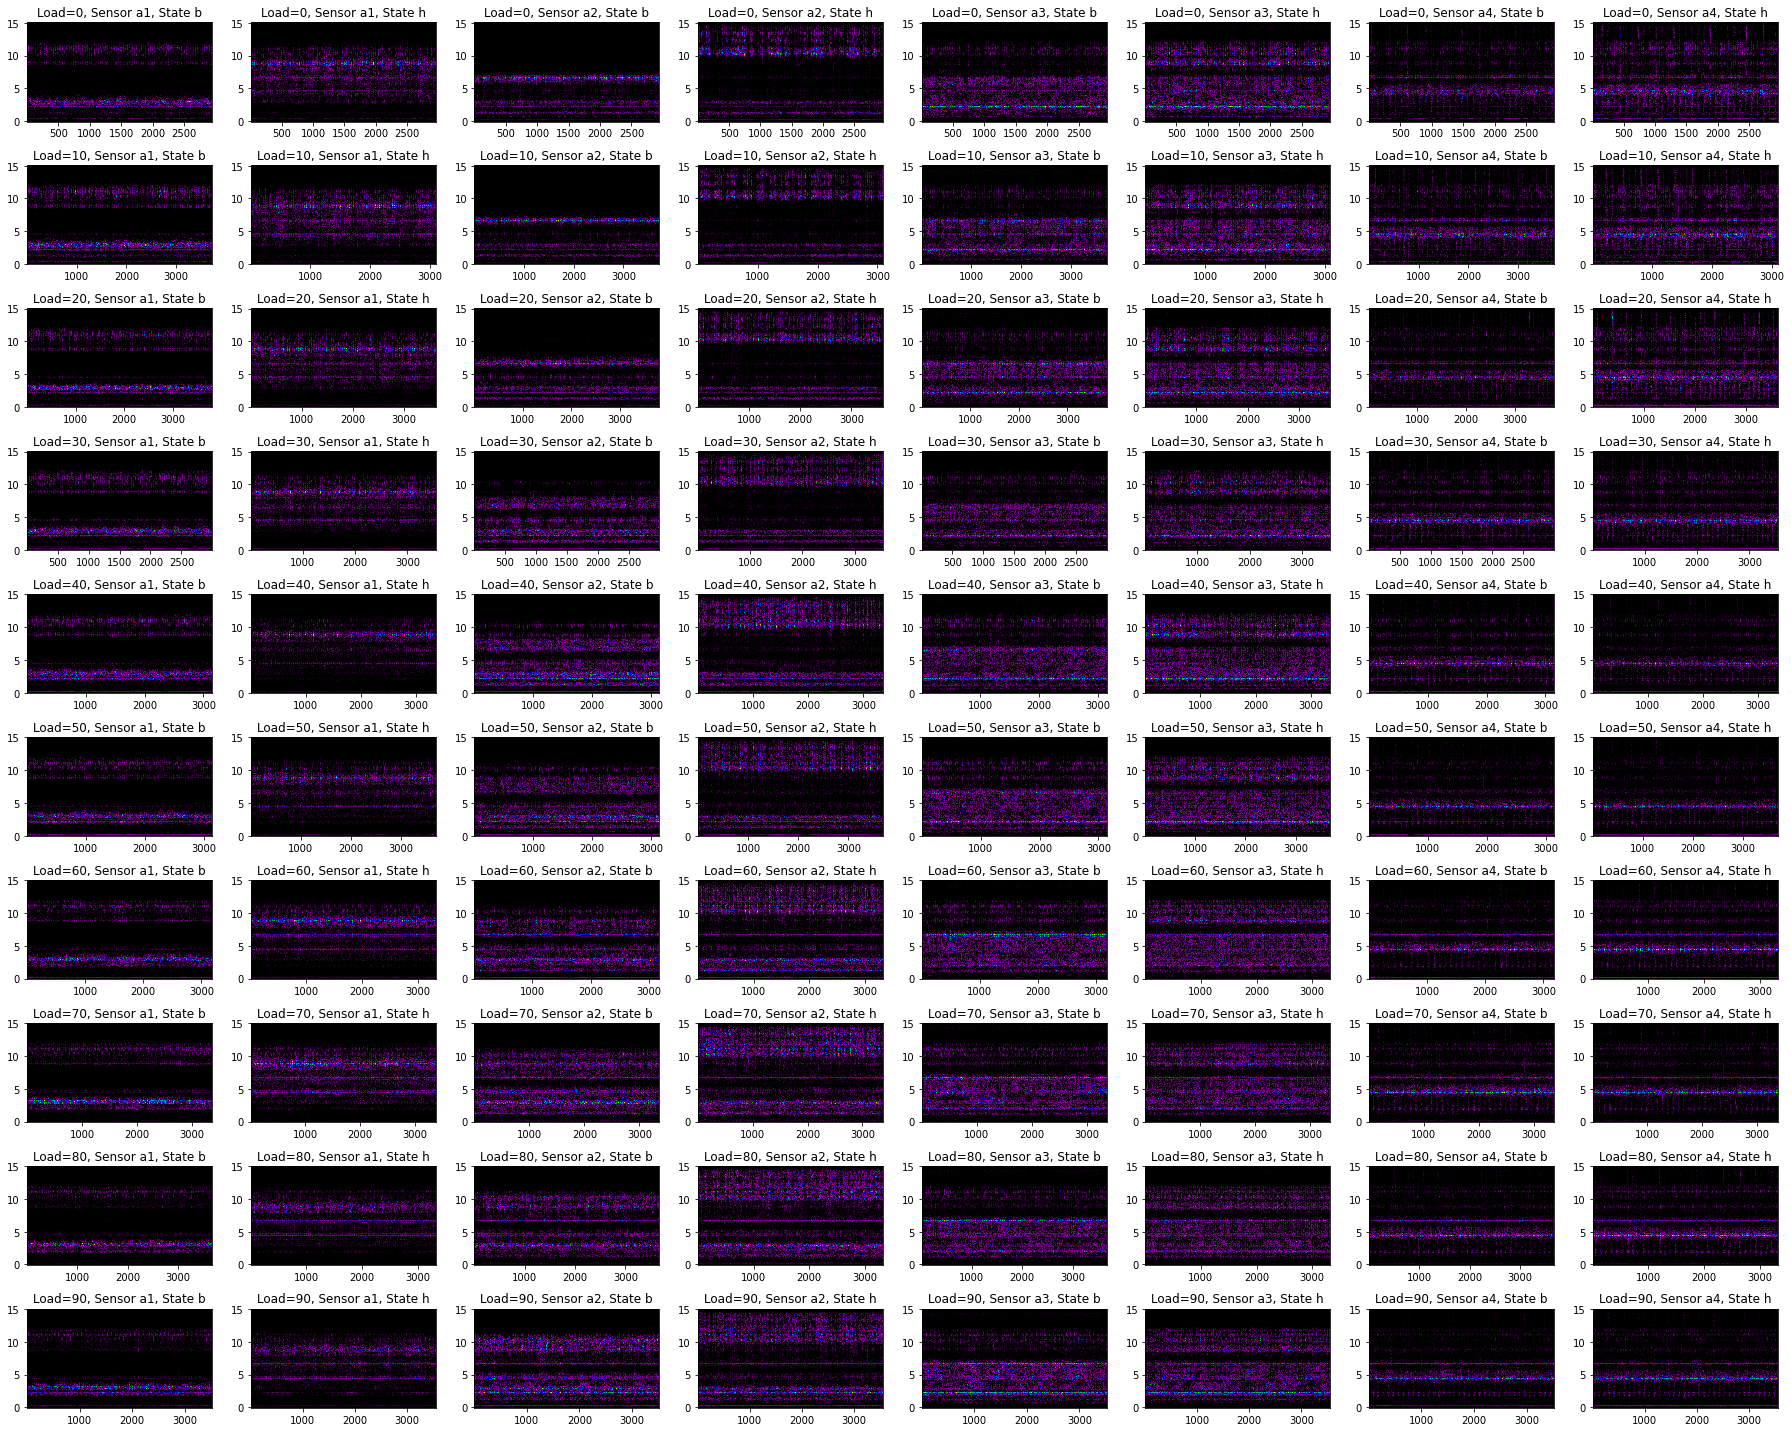

In [38]:
fig, ax = plt.subplots(ncols=8, nrows=10, figsize=(25,20))
for ((load, sensor, state), dfg), axi in tqdm(zip(sensor_readings.groupby(['load','sensor','state']), ax.ravel()), total=80):
    raw = dfg.reading.values
    f, t, Sxx = signal.spectrogram(raw, fs=30)  # 30Hz data rate
    axi.pcolormesh(t, f, Sxx, cmap='nipy_spectral')
    axi.set_title(f'Load={load}, Sensor {sensor}, State {state}')
plt.tight_layout()
plt.show()

The spectrum does not change over time.

In [40]:
data = []
labels = []
for (state,load,sensor),g in sensor_readings.groupby(['state','load','sensor']):
    vals = g.reading.values
    splits = np.split(vals, range(1000,vals.shape[0],1000))
    for s in splits[:-1]:  # except the last one
        data.append({
            'sensor_a1': int(sensor=='a1'),
            'sensor_a2': int(sensor=='a2'),
            'sensor_a3': int(sensor=='a3'),
            # no need to put a4: if a1-3 are 0, then it's sensor a4
            'load': load,
            'mean': np.mean(s),
            'std': np.std(s),
            'kurt': stats.kurtosis(s),
            'skew': stats.skew(s),
            'moment': stats.moment(s),
        })
        labels.append(int(state=='b'))  # positive label indicates fault

df_data = pd.DataFrame(data)
data = df_data.values
labels = np.array(labels)
(data.shape, labels.shape)

((8036, 9), (8036,))

In [41]:
print(f'Total samples: {len(labels)}')
print(f'Fault class: {np.sum(labels)} ({np.sum(labels)/len(labels):0.1%})')

Total samples: 8036
Fault class: 4000 (49.8%)


In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data, labels,
    train_size=0.8,
    random_state=42,
    stratify=labels
)
print(f'Training data: {X_train.shape}')
print(f'Test data: {X_test.shape}')

Training data: (6428, 9)
Test data: (1608, 9)


In [43]:
tpot_fd = TPOTClassifier(generations=5, random_state=42, max_time_mins=2)
tpot_fd.fit(X_train, y_train)
print(f'Best accuracy score: {tpot_fd.score(X_test, y_test):0.3%}')

Best accuracy score: 85.572%


In [44]:
pd.Series([
    model.split('(')[0]
    for model
    in tpot_fd.evaluated_individuals_.keys()
]).value_counts()

GaussianNB                1
RandomForestClassifier    1
dtype: int64